In [1]:
import pandas as pd

# Import the JCAMP-DX files into a dataframe

In [2]:
import os
import jcamp
import pandas as pd

# Directory containing the JCAMP-DX files
dir = "nist_files"

# Initialize an empty list to store data from each file
all_data = []

# Loop through all .jdx files in the directory
for filename in os.listdir(dir):
    file_path = os.path.join(dir, filename)
    
    # Read the JCAMP-DX file
    jdx_data = jcamp.jcamp_readfile(file_path)
    
    # Extract all available data
    data = {'filename': filename}
    for key, value in jdx_data.items():
        data[key] = value
    
    all_data.append(data)

# Create a pandas DataFrame from the collected data
df = pd.DataFrame(all_data)

# save to csv
df


KeyboardInterrupt: 

In [54]:
df.to_pickle('nist_data.pkl')


# Obtain SMILES

In [57]:
df = pd.read_pickle('nist_data.pkl')
df


,filename,title,jcamp-dx,data type,origin,owner,cas registry no,molform,$nist source,state,...,interferogram zerofill,spectral interval after zerofilling,apodization,folding limits,number of interferograms averaged per single channel spectrum,$spectra version,$uncertainty in y,sample description,pressure,temperature
0,nist_files/file_8028.jdx,2-Ethoxycinnamic acid,4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,69038-81-9,C 11 H 12 O 3,MSDC-IR,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nist_files/file_12061.jdx,DIAMYL MALEATE,4.24,INFRARED SPECTRUM,DOW CHEMICAL COMPANY,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,10099-71-5,C14 H24 O4,COBLENTZ,"SOLUTION (10% CCl4 FOR 2.5-7.5, 10% CS2 FOR 7....",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nist_files/file_14410.jdx,"M-NITRO CARBANILIC ACID, n-UNDECYL ESTER",4.24,INFRARED SPECTRUM,"CITRUS EXPERIMENT STATION, UNIVERSITY OF FLORI...",COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,95126-58-2,C18 H28 N2 O4,COBLENTZ,SOLID (1.7 mg / 200 mg KBr),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,nist_files/file_6005.jdx,"ACETOPHENONE, 2,4,5-TRIHYDROXY",4.24,INFRARED SPECTRUM,"TENNESSEE EASTMAN COMPANY, RESEARCH LABORATORIES",COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,1818-27-5,C8 H8 O4,COBLENTZ,SOLID (KBr PELLET),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nist_files/file_9336.jdx,"GLYCINONITRILE, 2,2-DIPHENYL-",4.24,INFRARED SPECTRUM,WYANDOTTE CHEMICALS CORP.,Copyright (C) 1987 by the Coblentz Society\nCo...,52460-99-8,C14 H12 N2,COBLENTZ,SOLID (OIL MULL),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15767,nist_files/file_13366.jdx,1-Benzyl-5-phenylbarbituric acid,4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,72846-00-5,C 17 H 14 N 2 O 3,MSDC-IR,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15768,nist_files/file_7302.jdx,"2,4,6-trichloroborazine",4.24,INFRARED SPECTRUM,NaN,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,933-18-6,H3 B3 Cl3 N3,COBLENTZ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15769,nist_files/file_8031.jdx,ETHYLBENZOYL ACETATE,4.24,INFRARED SPECTRUM,DOW CHEMICAL COMPANY,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,94-02-0,C11 H12 O3,COBLENTZ,"SOLUTION (10% CCl4 FOR 5000-1330, 10% CS2 FOR ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15770,nist_files/file_12078.jdx,"ACETIC ACID, NITRILOTRI-, TRISODIUM SALT",4.24,INFRARED SPECTRUM,STANDARD OIL OF OHIO,COBLENTZ SOC.\nCollection (C) 2018 copyright b...,NaN,C6 H6 N Na3 O6,COBLENTZ,SOLID (OIL MULL),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1) Retrieve InChI from NIST webpage, then convert to SMILES

In [3]:
import requests
from bs4 import BeautifulSoup
from rdkit import Chem
import time
import json
from tqdm import tqdm

def get_inchi_from_nist(cas_number):
    url = f"https://webbook.nist.gov/cgi/inchi?ID={cas_number}&Mask=80"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        script_elements = soup.find_all('script', type='application/ld+json')
        for script_element in script_elements:
            try:
                json_data = json.loads(script_element.string)
                inchi = json_data.get('inChI')
                if inchi:
                    return inchi
            except json.JSONDecodeError:
                continue
    return None

def inchi_to_smiles(inchi):
    mol = Chem.MolFromInchi(inchi)
    if mol:
        return Chem.MolToSmiles(mol)
    return None

# Import the ids.csv file
ids_df = pd.read_csv('ids.csv')

for index, row in tqdm(df.iterrows(), total=len(df), desc="Updating SMILES"):
    # Get the file number from the filename
    file_number = int(row['filename'].split('_')[-1].split('.')[0])
        
    # Get the corresponding row from ids_df (file number minus 1)
    corresponding_row = ids_df.iloc[file_number - 1]
    
    # Get the CAS number from the 'NIST ID' column
    cas_number = corresponding_row['NIST ID']
    inchi = get_inchi_from_nist(cas_number)
    if inchi:
        smiles = inchi_to_smiles(inchi)
        if smiles:
            df.at[index, 'smiles'] = smiles
            # print(f"Updated SMILES for index {index}, SMILES: {smiles}")
        else:
            print(f"Failed to convert InChI to SMILES for index {index}, CAS: {cas_number}")
            pass
    else:
        print(f"Failed to retrieve InChI for index {index}, CAS: {cas_number}")
        pass


df.to_csv('nist_data_with_smiles_updated.csv', index=False)


Updating SMILES:   1%|          | 137/15772 [00:17<32:28,  8.03it/s]

Failed to retrieve InChI for index 135, CAS: C3811049


Updating SMILES:   1%|          | 184/15772 [00:22<31:58,  8.13it/s][16:14:55] Explicit valence for atom # 13 N, 5, is greater than permitted
[16:14:55] ERROR: Explicit valence for atom # 13 N, 5, is greater than permitted

Updating SMILES:   1%|          | 186/15772 [00:23<32:06,  8.09it/s]

Failed to convert InChI to SMILES for index 184, CAS: C369380


Updating SMILES:   1%|▏         | 217/15772 [00:27<31:58,  8.11it/s][16:14:59] Explicit valence for atom # 6 N, 5, is greater than permitted
[16:14:59] ERROR: Explicit valence for atom # 6 N, 5, is greater than permitted

Updating SMILES:   1%|▏         | 219/15772 [00:27<32:06,  8.07it/s]

Failed to convert InChI to SMILES for index 217, CAS: B6001257


Updating SMILES:   4%|▍         | 662/15772 [01:27<30:10,  8.35it/s]  

Failed to retrieve InChI for index 660, CAS: C1617636


Updating SMILES:   5%|▌         | 813/15772 [01:48<33:50,  7.37it/s]  [16:16:20] Explicit valence for atom # 13 N, 5, is greater than permitted
[16:16:20] ERROR: Explicit valence for atom # 13 N, 5, is greater than permitted

Updating SMILES:   5%|▌         | 815/15772 [01:48<31:16,  7.97it/s]

Failed to convert InChI to SMILES for index 813, CAS: C116436307


Updating SMILES:   6%|▌         | 897/15772 [01:58<32:46,  7.56it/s]

Failed to retrieve InChI for index 895, CAS: C25014317


Updating SMILES:   7%|▋         | 1122/15772 [02:28<32:52,  7.43it/s] [16:17:00] Explicit valence for atom # 0 B, 6, is greater than permitted
[16:17:00] ERROR: Explicit valence for atom # 0 B, 6, is greater than permitted

Updating SMILES:   7%|▋         | 1124/15772 [02:28<31:26,  7.76it/s]

Failed to convert InChI to SMILES for index 1122, CAS: C18283937


Updating SMILES:   9%|▊         | 1374/15772 [03:00<30:03,  7.98it/s][16:17:33] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:17:33] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:   9%|▊         | 1376/15772 [03:00<30:09,  7.96it/s]

Failed to convert InChI to SMILES for index 1374, CAS: C7803636


Updating SMILES:  12%|█▏        | 1890/15772 [04:17<37:57,  6.10it/s]  

Failed to retrieve InChI for index 1888, CAS: C1341497


Updating SMILES:  16%|█▌        | 2470/15772 [05:33<28:46,  7.71it/s][16:20:06] Explicit valence for atom # 3 B, 5, is greater than permitted
[16:20:06] ERROR: Explicit valence for atom # 3 B, 5, is greater than permitted

Updating SMILES:  16%|█▌        | 2472/15772 [05:34<28:26,  7.79it/s]

Failed to convert InChI to SMILES for index 2470, CAS: B6000846


Updating SMILES:  19%|█▉        | 3043/15772 [07:03<28:17,  7.50it/s]  [16:21:35] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:21:35] ERROR: Explicit valence for atom # 13 N, 4, is greater than permitted

Updating SMILES:  19%|█▉        | 3045/15772 [07:03<30:27,  6.96it/s]

Failed to convert InChI to SMILES for index 3043, CAS: C13673308


Updating SMILES:  21%|██        | 3321/15772 [07:40<27:46,  7.47it/s]  [16:22:13] Explicit valence for atom # 3 H, 2, is greater than permitted
[16:22:13] ERROR: Explicit valence for atom # 3 H, 2, is greater than permitted

Updating SMILES:  21%|██        | 3323/15772 [07:40<27:20,  7.59it/s]

Failed to convert InChI to SMILES for index 3321, CAS: B6000834


Updating SMILES:  22%|██▏       | 3428/15772 [07:56<29:26,  6.99it/s]  

Failed to retrieve InChI for index 3426, CAS: C55589623


Updating SMILES:  26%|██▌       | 4070/15772 [09:39<24:48,  7.86it/s]  

Failed to retrieve InChI for index 4068, CAS: C497198


Updating SMILES:  28%|██▊       | 4349/15772 [10:16<23:59,  7.94it/s]  

Failed to retrieve InChI for index 4347, CAS: C9002884


Updating SMILES:  28%|██▊       | 4387/15772 [10:21<23:53,  7.94it/s]

Failed to retrieve InChI for index 4385, CAS: C1320167


Updating SMILES:  28%|██▊       | 4389/15772 [10:21<24:01,  7.90it/s]

Failed to retrieve InChI for index 4387, CAS: C1855636


Updating SMILES:  30%|███       | 4753/15772 [11:12<22:49,  8.04it/s]  [16:25:44] Explicit valence for atom # 20 N, 5, is greater than permitted
[16:25:44] ERROR: Explicit valence for atom # 20 N, 5, is greater than permitted

Updating SMILES:  30%|███       | 4755/15772 [11:12<23:02,  7.97it/s]

Failed to convert InChI to SMILES for index 4753, CAS: C58493542


Updating SMILES:  30%|███       | 4806/15772 [11:18<23:00,  7.94it/s]

Failed to retrieve InChI for index 4804, CAS: C9002895


Updating SMILES:  31%|███▏      | 4938/15772 [11:36<24:38,  7.33it/s][16:26:08] Explicit valence for atom # 6 N, 5, is greater than permitted
[16:26:08] ERROR: Explicit valence for atom # 6 N, 5, is greater than permitted

Updating SMILES:  31%|███▏      | 4940/15772 [11:36<23:49,  7.58it/s]

Failed to convert InChI to SMILES for index 4938, CAS: C590465


Updating SMILES:  32%|███▏      | 4974/15772 [11:40<22:32,  7.98it/s][16:26:13] Explicit valence for atom # 15 N, 5, is greater than permitted
[16:26:13] ERROR: Explicit valence for atom # 15 N, 5, is greater than permitted

Updating SMILES:  32%|███▏      | 4976/15772 [11:41<22:31,  7.99it/s]

Failed to convert InChI to SMILES for index 4974, CAS: B6009957


Updating SMILES:  32%|███▏      | 4995/15772 [11:43<22:19,  8.04it/s]

Failed to retrieve InChI for index 4993, CAS: C9003536


Updating SMILES:  32%|███▏      | 5110/15772 [11:58<22:42,  7.82it/s]

Failed to retrieve InChI for index 5108, CAS: C21645512


Updating SMILES:  32%|███▏      | 5113/15772 [11:58<25:17,  7.02it/s]

Failed to retrieve InChI for index 5111, CAS: C25340174


Updating SMILES:  33%|███▎      | 5194/15772 [12:10<22:24,  7.87it/s]  

Failed to retrieve InChI for index 5192, CAS: C70289428


Updating SMILES:  35%|███▌      | 5570/15772 [13:00<21:17,  7.99it/s]  [16:27:33] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:27:33] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  35%|███▌      | 5572/15772 [13:01<21:24,  7.94it/s]

Failed to convert InChI to SMILES for index 5570, CAS: C7773060


Updating SMILES:  35%|███▌      | 5586/15772 [13:03<21:13,  8.00it/s]

Failed to retrieve InChI for index 5584, CAS: C2872528


Updating SMILES:  36%|███▌      | 5640/15772 [13:09<20:59,  8.04it/s]

Failed to retrieve InChI for index 5639, CAS: C1617625


Updating SMILES:  39%|███▉      | 6147/15772 [14:29<21:33,  7.44it/s][16:29:01] Explicit valence for atom # 10 N, 5, is greater than permitted
[16:29:01] ERROR: Explicit valence for atom # 10 N, 5, is greater than permitted

Updating SMILES:  39%|███▉      | 6149/15772 [14:29<20:56,  7.66it/s]

Failed to convert InChI to SMILES for index 6147, CAS: C138249


Updating SMILES:  39%|███▉      | 6206/15772 [14:36<21:54,  7.28it/s][16:29:09] Explicit valence for atom # 13 N, 4, is greater than permitted
[16:29:09] ERROR: Explicit valence for atom # 13 N, 4, is greater than permitted

Updating SMILES:  39%|███▉      | 6208/15772 [14:36<21:22,  7.46it/s]

Failed to convert InChI to SMILES for index 6206, CAS: C84309331


Updating SMILES:  43%|████▎     | 6796/15772 [15:54<19:50,  7.54it/s]  [16:30:27] Explicit valence for atom # 7 N, 5, is greater than permitted
[16:30:27] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted

Updating SMILES:  43%|████▎     | 6798/15772 [15:54<19:28,  7.68it/s]

Failed to convert InChI to SMILES for index 6796, CAS: C999815


Updating SMILES:  43%|████▎     | 6852/15772 [16:01<19:07,  7.77it/s]

Failed to retrieve InChI for index 6850, CAS: C7775099


Updating SMILES:  44%|████▎     | 6891/15772 [16:06<18:20,  8.07it/s]

Failed to retrieve InChI for index 6889, CAS: C59115901


Updating SMILES:  44%|████▍     | 6911/15772 [16:09<19:26,  7.59it/s][16:30:42] Explicit valence for atom # 1 N, 5, is greater than permitted
[16:30:42] ERROR: Explicit valence for atom # 1 N, 5, is greater than permitted

Updating SMILES:  44%|████▍     | 6913/15772 [16:09<18:45,  7.87it/s]

Failed to convert InChI to SMILES for index 6911, CAS: C7790989


Updating SMILES:  44%|████▍     | 6935/15772 [16:12<18:22,  8.02it/s]

Failed to retrieve InChI for index 6933, CAS: C14807966


Updating SMILES:  44%|████▍     | 6970/15772 [16:17<20:03,  7.31it/s][16:30:49] Explicit valence for atom # 0 B, 5, is greater than permitted
[16:30:49] ERROR: Explicit valence for atom # 0 B, 5, is greater than permitted

Updating SMILES:  44%|████▍     | 6972/15772 [16:17<21:23,  6.86it/s]

Failed to convert InChI to SMILES for index 6970, CAS: B6000841


Updating SMILES:  45%|████▍     | 7052/15772 [16:27<18:21,  7.91it/s]

Failed to retrieve InChI for index 7050, CAS: C7601549


Updating SMILES:  46%|████▌     | 7191/15772 [16:45<18:08,  7.88it/s][16:31:18] Explicit valence for atom # 2 B, 5, is greater than permitted
[16:31:18] ERROR: Explicit valence for atom # 2 B, 5, is greater than permitted

Updating SMILES:  46%|████▌     | 7193/15772 [16:45<18:14,  7.84it/s]

Failed to convert InChI to SMILES for index 7191, CAS: B6000844


Updating SMILES:  48%|████▊     | 7604/15772 [17:41<21:05,  6.45it/s]  

Failed to retrieve InChI for index 7602, CAS: C6247003


Updating SMILES:  48%|████▊     | 7643/15772 [17:46<16:36,  8.16it/s][16:32:18] Explicit valence for atom # 0 B, 5, is greater than permitted
[16:32:18] ERROR: Explicit valence for atom # 0 B, 5, is greater than permitted

Updating SMILES:  48%|████▊     | 7645/15772 [17:46<17:22,  7.79it/s]

Failed to convert InChI to SMILES for index 7643, CAS: B6000843


Updating SMILES:  50%|████▉     | 7880/15772 [18:17<18:19,  7.18it/s][16:32:49] Explicit valence for atom # 29 N, 5, is greater than permitted
[16:32:49] ERROR: Explicit valence for atom # 29 N, 5, is greater than permitted

Updating SMILES:  50%|████▉     | 7882/15772 [18:17<17:22,  7.57it/s]

Failed to convert InChI to SMILES for index 7880, CAS: C4368518


Updating SMILES:  50%|█████     | 7944/15772 [18:25<16:20,  7.98it/s]

Failed to retrieve InChI for index 7942, CAS: C1333886


Updating SMILES:  53%|█████▎    | 8304/15772 [19:12<16:40,  7.46it/s]

Failed to retrieve InChI for index 8302, CAS: B6009512


Updating SMILES:  53%|█████▎    | 8371/15772 [19:21<16:02,  7.69it/s]

Failed to retrieve InChI for index 8369, CAS: C688993


Updating SMILES:  53%|█████▎    | 8401/15772 [19:25<17:35,  6.98it/s][16:33:58] Explicit valence for atom # 12 N, 4, is greater than permitted
[16:33:58] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted

Updating SMILES:  53%|█████▎    | 8403/15772 [19:25<16:40,  7.37it/s]

Failed to convert InChI to SMILES for index 8401, CAS: B6008673


Updating SMILES:  54%|█████▍    | 8488/15772 [19:36<15:02,  8.07it/s]

Failed to retrieve InChI for index 8486, CAS: B6009513


Updating SMILES:  54%|█████▍    | 8538/15772 [19:43<15:38,  7.71it/s][16:34:16] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:34:16] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  54%|█████▍    | 8540/15772 [19:44<15:31,  7.76it/s]

Failed to convert InChI to SMILES for index 8538, CAS: B6000559


Updating SMILES:  55%|█████▍    | 8623/15772 [19:54<14:46,  8.07it/s]

Failed to retrieve InChI for index 8621, CAS: C625309


Updating SMILES:  55%|█████▍    | 8670/15772 [20:00<14:55,  7.93it/s]

Failed to retrieve InChI for index 8668, CAS: C1335406


Updating SMILES:  57%|█████▋    | 9024/15772 [20:47<15:48,  7.12it/s][16:35:20] Explicit valence for atom # 5 B, 11, is greater than permitted
[16:35:20] ERROR: Explicit valence for atom # 5 B, 11, is greater than permitted

Updating SMILES:  57%|█████▋    | 9026/15772 [20:47<15:10,  7.41it/s]

Failed to convert InChI to SMILES for index 9024, CAS: C23777802


Updating SMILES:  58%|█████▊    | 9139/15772 [21:03<14:28,  7.64it/s][16:35:36] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Missing, Attachment points; Charge(s): Do not match)

Updating SMILES:  59%|█████▊    | 9246/15772 [21:17<15:20,  7.09it/s][16:35:50] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:35:50] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  59%|█████▊    | 9248/15772 [21:17<14:33,  7.47it/s]

Failed to convert InChI to SMILES for index 9246, CAS: B6000577


Updating SMILES:  59%|█████▉    | 9325/15772 [21:28<15:12,  7.07it/s][16:36:01] Explicit valence for atom # 18 S, 8, is greater than permitted
[16:36:01] ERROR: Explicit valence for atom # 18 S, 8, is greater than permitted

Updating SMILES:  59%|█████▉    | 9327/15772 [21:28<14:27,  7.43it/s]

Failed to convert InChI to SMILES for index 9325, CAS: B6007932


Updating SMILES:  59%|█████▉    | 9342/15772 [21:30<13:30,  7.93it/s]

Failed to retrieve InChI for index 9340, CAS: C1309360


Updating SMILES:  60%|█████▉    | 9444/15772 [21:43<14:31,  7.26it/s]

Failed to retrieve InChI for index 9442, CAS: C27554263


Updating SMILES:  60%|██████    | 9538/15772 [21:56<13:07,  7.92it/s]

Failed to retrieve InChI for index 9536, CAS: C10422352


Updating SMILES:  61%|██████    | 9629/15772 [22:08<12:46,  8.02it/s][16:36:40] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:36:40] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  61%|██████    | 9631/15772 [22:08<12:55,  7.92it/s]

Failed to convert InChI to SMILES for index 9629, CAS: C6484522


Updating SMILES:  68%|██████▊   | 10718/15772 [25:29<10:26,  8.07it/s]   [16:40:01] WARNING: not removing hydrogen atom without neighbors
[16:40:01] WARNING: not removing hydrogen atom without neighbors
[16:40:01] WARNING: not removing hydrogen atom without neighbors
Updating SMILES:  68%|██████▊   | 10796/15772 [25:39<11:53,  6.98it/s][16:40:11] Explicit valence for atom # 2 H, 2, is greater than permitted
[16:40:11] ERROR: Explicit valence for atom # 2 H, 2, is greater than permitted

Updating SMILES:  68%|██████▊   | 10798/15772 [25:39<11:02,  7.51it/s]

Failed to convert InChI to SMILES for index 10796, CAS: C19287457


Updating SMILES:  71%|███████   | 11222/15772 [26:35<09:36,  7.89it/s]

Failed to retrieve InChI for index 11220, CAS: C9004700


Updating SMILES:  73%|███████▎  | 11504/15772 [27:12<08:58,  7.92it/s][16:41:44] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:41:44] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  73%|███████▎  | 11506/15772 [27:12<08:57,  7.93it/s]

Failed to convert InChI to SMILES for index 11504, CAS: C7783202


Updating SMILES:  73%|███████▎  | 11558/15772 [27:19<08:58,  7.82it/s]

Failed to retrieve InChI for index 11556, CAS: C126636


Updating SMILES:  73%|███████▎  | 11592/15772 [27:23<08:43,  7.99it/s][16:41:56] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:41:56] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  74%|███████▎  | 11594/15772 [27:23<08:40,  8.03it/s]

Failed to convert InChI to SMILES for index 11592, CAS: B6004196


Updating SMILES:  76%|███████▋  | 12028/15772 [28:22<10:06,  6.17it/s][16:42:55] Explicit valence for atom # 0 B, 5, is greater than permitted
[16:42:55] ERROR: Explicit valence for atom # 0 B, 5, is greater than permitted

Updating SMILES:  76%|███████▋  | 12030/15772 [28:22<09:04,  6.87it/s]

Failed to convert InChI to SMILES for index 12028, CAS: B6000842


Updating SMILES:  77%|███████▋  | 12114/15772 [28:33<07:49,  7.78it/s]

Failed to retrieve InChI for index 12112, CAS: C1192898


Updating SMILES:  81%|████████  | 12804/15772 [30:06<06:14,  7.92it/s][16:44:39] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:44:39] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  81%|████████  | 12806/15772 [30:06<06:29,  7.61it/s]

Failed to convert InChI to SMILES for index 12804, CAS: B6000553


Updating SMILES:  84%|████████▍ | 13240/15772 [31:04<05:34,  7.56it/s]

Failed to retrieve InChI for index 13238, CAS: C25321099


Updating SMILES:  84%|████████▍ | 13281/15772 [31:10<07:39,  5.43it/s][16:45:42] Explicit valence for atom # 1 N, 5, is greater than permitted
[16:45:42] ERROR: Explicit valence for atom # 1 N, 5, is greater than permitted

Updating SMILES:  84%|████████▍ | 13283/15772 [31:10<06:27,  6.42it/s]

Failed to convert InChI to SMILES for index 13281, CAS: B6000536


Updating SMILES:  84%|████████▍ | 13305/15772 [31:13<05:23,  7.62it/s]

Failed to retrieve InChI for index 13303, CAS: C37769623


Updating SMILES:  85%|████████▍ | 13376/15772 [31:22<05:00,  7.98it/s][16:45:54] Explicit valence for atom # 4 N, 5, is greater than permitted
[16:45:54] ERROR: Explicit valence for atom # 4 N, 5, is greater than permitted

Updating SMILES:  85%|████████▍ | 13378/15772 [31:22<05:00,  7.97it/s]

Failed to convert InChI to SMILES for index 13376, CAS: B6006876


Updating SMILES:  85%|████████▍ | 13404/15772 [31:25<04:59,  7.91it/s]

Failed to retrieve InChI for index 13402, CAS: B6009642


Updating SMILES:  85%|████████▌ | 13452/15772 [31:32<05:19,  7.26it/s]

Failed to retrieve InChI for index 13450, CAS: C2268464


Updating SMILES:  89%|████████▉ | 14047/15772 [32:52<03:37,  7.94it/s]

Failed to retrieve InChI for index 14045, CAS: C1118463


Updating SMILES:  89%|████████▉ | 14084/15772 [32:57<03:33,  7.91it/s][16:47:29] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)

Updating SMILES:  90%|████████▉ | 14173/15772 [33:08<03:17,  8.09it/s][16:47:40] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:47:40] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  90%|████████▉ | 14175/15772 [33:08<03:19,  8.00it/s]

Failed to convert InChI to SMILES for index 14173, CAS: C7722761


Updating SMILES:  93%|█████████▎| 14671/15772 [34:12<02:23,  7.69it/s]

Failed to retrieve InChI for index 14669, CAS: C9003274


Updating SMILES:  94%|█████████▍| 14848/15772 [34:36<01:56,  7.90it/s][16:49:09] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)

Updating SMILES:  95%|█████████▌| 15045/15772 [35:02<01:31,  7.97it/s][16:49:34] Explicit valence for atom # 0 N, 5, is greater than permitted
[16:49:34] ERROR: Explicit valence for atom # 0 N, 5, is greater than permitted

Updating SMILES:  95%|█████████▌| 15047/15772 [35:02<01:31,  7.97it/s]

Failed to convert InChI to SMILES for index 15045, CAS: C7803658


Updating SMILES:  97%|█████████▋| 15270/15772 [35:31<01:03,  7.86it/s]

Failed to retrieve InChI for index 15268, CAS: C615996


Updating SMILES:  98%|█████████▊| 15418/15772 [35:50<00:45,  7.79it/s]

Failed to retrieve InChI for index 15416, CAS: C1321739


Updating SMILES:  98%|█████████▊| 15456/15772 [35:55<00:39,  8.09it/s][16:50:27] Explicit valence for atom # 0 B, 5, is greater than permitted
[16:50:27] ERROR: Explicit valence for atom # 0 B, 5, is greater than permitted

Updating SMILES:  98%|█████████▊| 15458/15772 [35:55<00:38,  8.05it/s]

Failed to convert InChI to SMILES for index 15456, CAS: B6000825


Updating SMILES:  99%|█████████▉| 15612/15772 [36:15<00:20,  7.84it/s]

Failed to retrieve InChI for index 15610, CAS: C1305620


Updating SMILES:  99%|█████████▉| 15639/15772 [36:18<00:16,  7.83it/s]

Failed to retrieve InChI for index 15637, CAS: C10043524


Updating SMILES: 100%|██████████| 15772/15772 [36:35<00:00,  7.18it/s]


### 2) Search up CAS numbers on CAS webpage

In [8]:
import requests
from tqdm import tqdm

def cas_to_smiles(cas_number):
    # PubChem PUG REST API URL for converting CAS to SMILES
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas_number}/property/CanonicalSMILES/JSON"
    
    # Send a request to PubChem
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        # Extract SMILES from the response
        smiles = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
        return smiles
    else:
        return None

# Update SMILES for rows where it's NaN using CAS numbers
for index, row in tqdm(df[df['smiles'].isna()].iterrows(), total=df['smiles'].isna().sum(), desc="Updating SMILES from CAS"):
    cas_number = row['cas registry no']
    
    # Check if the CAS number is not NaN
    if pd.notna(cas_number):
        smiles = cas_to_smiles(cas_number)
        if smiles:
            df.at[index, 'smiles'] = smiles
        else:
            print(f"Failed to retrieve SMILES for index {index}, CAS: {cas_number}")
    else:
        print(f"CAS number is NaN for index {index}")



# Print the number of remaining NaN values in the SMILES column
remaining_nan = df['smiles'].isna().sum()
print(f"Number of remaining NaN values in SMILES column: {remaining_nan}")



Updating SMILES from CAS:   5%|▌         | 4/79 [00:00<00:06, 11.20it/s]

Failed to retrieve SMILES for index 184, CAS: 369-38-0
CAS number is NaN for index 217


Updating SMILES from CAS:   8%|▊         | 6/79 [00:00<00:07,  9.86it/s]

Failed to retrieve SMILES for index 813, CAS: 116436-30-7


Updating SMILES from CAS:  11%|█▏        | 9/79 [00:01<00:08,  8.03it/s]

Failed to retrieve SMILES for index 1374, CAS: 7803-63-6
Failed to retrieve SMILES for index 1888, CAS: 1341-49-7
CAS number is NaN for index 2470


Updating SMILES from CAS:  16%|█▋        | 13/79 [00:01<00:05, 11.50it/s]

CAS number is NaN for index 3321


Updating SMILES from CAS:  25%|██▌       | 20/79 [00:03<00:16,  3.56it/s]

Failed to retrieve SMILES for index 4804, CAS: 9002-89-5
CAS number is NaN for index 4974


Updating SMILES from CAS:  30%|███       | 24/79 [00:03<00:08,  6.54it/s]

Failed to retrieve SMILES for index 5108, CAS: 21645-51-2
Failed to retrieve SMILES for index 5111, CAS: 25340-17-4


Updating SMILES from CAS:  39%|███▉      | 31/79 [00:04<00:07,  6.16it/s]

Failed to retrieve SMILES for index 6206, CAS: 84309-33-1


Updating SMILES from CAS:  47%|████▋     | 37/79 [00:05<00:04,  9.92it/s]

CAS number is NaN for index 6970
CAS number is NaN for index 7191


Updating SMILES from CAS:  52%|█████▏    | 41/79 [00:05<00:02, 12.75it/s]

CAS number is NaN for index 7643


Updating SMILES from CAS:  56%|█████▌    | 44/79 [00:05<00:02, 14.78it/s]

Failed to retrieve SMILES for index 7942, CAS: 1333-88-6
CAS number is NaN for index 8302
Failed to retrieve SMILES for index 8369, CAS: 688-99-3
CAS number is NaN for index 8401
CAS number is NaN for index 8486
CAS number is NaN for index 8538
Failed to retrieve SMILES for index 8621, CAS: 625-30-9


Updating SMILES from CAS:  62%|██████▏   | 49/79 [00:05<00:01, 20.39it/s]

Failed to retrieve SMILES for index 8668, CAS: 1335-40-6
Failed to retrieve SMILES for index 9024, CAS: 23777-80-2
CAS number is NaN for index 9246
CAS number is NaN for index 9325


Updating SMILES from CAS:  80%|███████▉  | 63/79 [00:07<00:01, 12.90it/s]

CAS number is NaN for index 11592
CAS number is NaN for index 12028
CAS number is NaN for index 12804


Updating SMILES from CAS:  85%|████████▍ | 67/79 [00:07<00:00, 13.97it/s]

CAS number is NaN for index 13281
CAS number is NaN for index 13376
CAS number is NaN for index 13402


Updating SMILES from CAS:  94%|█████████▎| 74/79 [00:07<00:00, 12.46it/s]

Failed to retrieve SMILES for index 15045, CAS: 7803-65-8


Updating SMILES from CAS: 100%|██████████| 79/79 [00:08<00:00,  9.55it/s]

CAS number is NaN for index 15456
Failed to retrieve SMILES for index 15610, CAS: 1305-62-0
Failed to retrieve SMILES for index 15637, CAS: 10043-52-4
Number of remaining NaN values in SMILES column: 36


### 3) Manually add SMILES for the remaining rows

In [79]:
# Get the filenumber from the filename
filenumber = int(df['filename'][15637].split('_')[-1].split('.')[0])

# Read the ids.csv file
ids_df = pd.read_csv('ids.csv')

# Get the NIST ID from the row number minus 1
nist_id = ids_df.iloc[filenumber - 1]['NIST ID']

print(f"Filenumber: {filenumber}")
print(f"NIST ID: {nist_id}")


Filenumber: 1217
NIST ID: C10043524


In [81]:
df.loc[184, 'smiles'] = 'C[N+](C)(C)CCOC1=CC=CC(=C1)[N+](=O)[O-].[Br-]'
df.loc[217, 'smiles'] = 'CCCCNOS(=O)(=O)CC(=O)O'
df.loc[813, 'smiles'] = 'C[N+](C)(C)CCOC1=CC=CC=C1[N+](=O)[O-].[Br-]'
df.loc[1374, 'smiles'] = '[NH4+].OS(=O)(=O)[O-]'
df.loc[1888, 'smiles'] = None
df.loc[2470, 'smiles'] = None
df.loc[3321, 'smiles'] = None
df.loc[4804, 'smiles'] = None
df.loc[4974, 'smiles'] = 'C[N+](C)(C)C1=CC=CC=C1.C1=CC=C(C=C1)S(=O)(=O)[O-]'
df.loc[5108, 'smiles'] = None
df.loc[5111, 'smiles'] = 'CCC1=CC=C(C=C1)CC'
df.loc[6206, 'smiles'] = None
df.loc[6970, 'smiles'] = None
df.loc[7191, 'smiles'] = None
df.loc[7643, 'smiles'] = None
df.loc[7942, 'smiles'] = None
df.loc[8302, 'smiles'] = 'CCS'
df.loc[8369, 'smiles'] = 'CCC(CC=C)O'
df.loc[8401, 'smiles'] = 'C[N+]1=C2C(=NC=NC2=[N+](N=C1)C)Cl.Cl'
df.loc[8486, 'smiles'] = None
df.loc[8538, 'smiles'] = '[NH4+].[NH4+].[O-]S(=O)(=O)OOS(=O)(=O)[O-]'
df.loc[8621, 'smiles'] = 'CCCC(C)N'
df.loc[8668, 'smiles'] = 'CCOC(=O)C1=CC=CO1'
df.loc[9024, 'smiles'] = None
df.loc[9246, 'smiles'] = '[NH4+].[NH4+].OP(=O)([O-])[O-]'
df.loc[9325, 'smiles'] = None
df.loc[11592, 'smiles'] = '[NH4+].[NH4+].[O-][Se](=O)(=O)[O-]'
df.loc[12028, 'smiles'] = None
df.loc[12804, 'smiles'] = '[NH4+].[NH4+].[O-]S(=O)(=S)[O-]'
df.loc[13281, 'smiles'] = '[NH3+]O[N+](O)([O-])O[N+](=O)[O-].[NH3+]O[N+](O)([O-])O[N+](=O)[O-].[N+](=O)(O)[O-].[N+](=O)(O)[O-].[Ce]'
df.loc[13376, 'smiles'] = None
df.loc[13402, 'smiles'] = 'CC.CCCCCCCCCCCCCCCCCC(=O)OC'
df.loc[15045, 'smiles'] = None
df.loc[15456, 'smiles'] = None
df.loc[15610, 'smiles'] = '[OH-].[OH-].[Ca+2]'
df.loc[15637, 'smiles'] = '[Cl-].[Cl-].[Ca+2]'

### Drop remaining rows with NaN SMILES

In [146]:
# Drop rows with NaN SMILES
df = df.dropna(subset=['smiles'])

# Reset the index after dropping rows
df = df.reset_index(drop=True)

# Print the number of remaining rows
print(f"Number of rows after dropping NaN SMILES: {len(df)}")

df


Number of rows after dropping NaN SMILES: 15755


,filename,title,jcamp-dx,data type,origin,owner,cas registry no,molform,$nist source,state,...,spectral interval after zerofilling,apodization,folding limits,number of interferograms averaged per single channel spectrum,$spectra version,$uncertainty in y,sample description,pressure,temperature,smiles
0,nist_files/file_8028.jdx,2-Ethoxycinnamic acid,4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,69038-81-9,C 11 H 12 O 3,MSDC-IR,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCOc1ccccc1/C=C/C(=O)O
1,nist_files/file_12061.jdx,DIAMYL MALEATE,4.24,INFRARED SPECTRUM,DOW CHEMICAL COMPANY,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,10099-71-5,C14 H24 O4,COBLENTZ,"SOLUTION (10% CCl4 FOR 2.5-7.5, 10% CS2 FOR 7....",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCOC(=O)/C=C\C(=O)OCCCCC
2,nist_files/file_14410.jdx,"M-NITRO CARBANILIC ACID, n-UNDECYL ESTER",4.24,INFRARED SPECTRUM,"CITRUS EXPERIMENT STATION, UNIVERSITY OF FLORI...",COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,95126-58-2,C18 H28 N2 O4,COBLENTZ,SOLID (1.7 mg / 200 mg KBr),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCCCCCCCOC(O)=Nc1cccc([N+](=O)[O-])c1
3,nist_files/file_6005.jdx,"ACETOPHENONE, 2,4,5-TRIHYDROXY",4.24,INFRARED SPECTRUM,"TENNESSEE EASTMAN COMPANY, RESEARCH LABORATORIES",COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,1818-27-5,C8 H8 O4,COBLENTZ,SOLID (KBr PELLET),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC(=O)c1cc(O)c(O)cc1O
4,nist_files/file_9336.jdx,"GLYCINONITRILE, 2,2-DIPHENYL-",4.24,INFRARED SPECTRUM,WYANDOTTE CHEMICALS CORP.,Copyright (C) 1987 by the Coblentz Society\nCo...,52460-99-8,C14 H12 N2,COBLENTZ,SOLID (OIL MULL),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N#CC(N)(c1ccccc1)c1ccccc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15750,nist_files/file_13366.jdx,1-Benzyl-5-phenylbarbituric acid,4.24,INFRARED SPECTRUM,EPA-IR VAPOR PHASE LIBRARY,SRD/NIST\nCollection (C) 2018 copyright by the...,72846-00-5,C 17 H 14 N 2 O 3,MSDC-IR,gas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C1N=C(O)C(c2ccccc2)C(=O)N1Cc1ccccc1
15751,nist_files/file_7302.jdx,"2,4,6-trichloroborazine",4.24,INFRARED SPECTRUM,NaN,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,933-18-6,H3 B3 Cl3 N3,COBLENTZ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ClB1NB(Cl)NB(Cl)N1
15752,nist_files/file_8031.jdx,ETHYLBENZOYL ACETATE,4.24,INFRARED SPECTRUM,DOW CHEMICAL COMPANY,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,94-02-0,C11 H12 O3,COBLENTZ,"SOLUTION (10% CCl4 FOR 5000-1330, 10% CS2 FOR ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCOC(=O)CC(=O)c1ccccc1
15753,nist_files/file_12078.jdx,"ACETIC ACID, NITRILOTRI-, TRISODIUM SALT",4.24,INFRARED SPECTRUM,STANDARD OIL OF OHIO,COBLENTZ SOC.\nCollection (C) 2018 copyright b...,NaN,C6 H6 N Na3 O6,COBLENTZ,SOLID (OIL MULL),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C([O-])CN(CC(=O)[O-])CC(=O)[O-].[Na+].[Na+]....


### Save the dataframe

In [147]:
df.to_pickle('nist_data_with_smiles.pkl')

# Preprocess the IR spectra

In [3]:
df = pd.read_pickle('nist_data_with_smiles.pkl')

### 1) Drop rows with NaN values in firstx, lastx, yunits, and xunits

In [4]:
# Drop rows with NaN values in specified columns
df = df.dropna(subset=['firstx', 'lastx', 'yunits', 'xunits'])

# Reset the index after dropping rows
df = df.reset_index(drop=True)

print(f"Number of rows after dropping NaN values: {len(df)}")

Number of rows after dropping NaN values: 14957


### 2) Standardize the IR spectra units

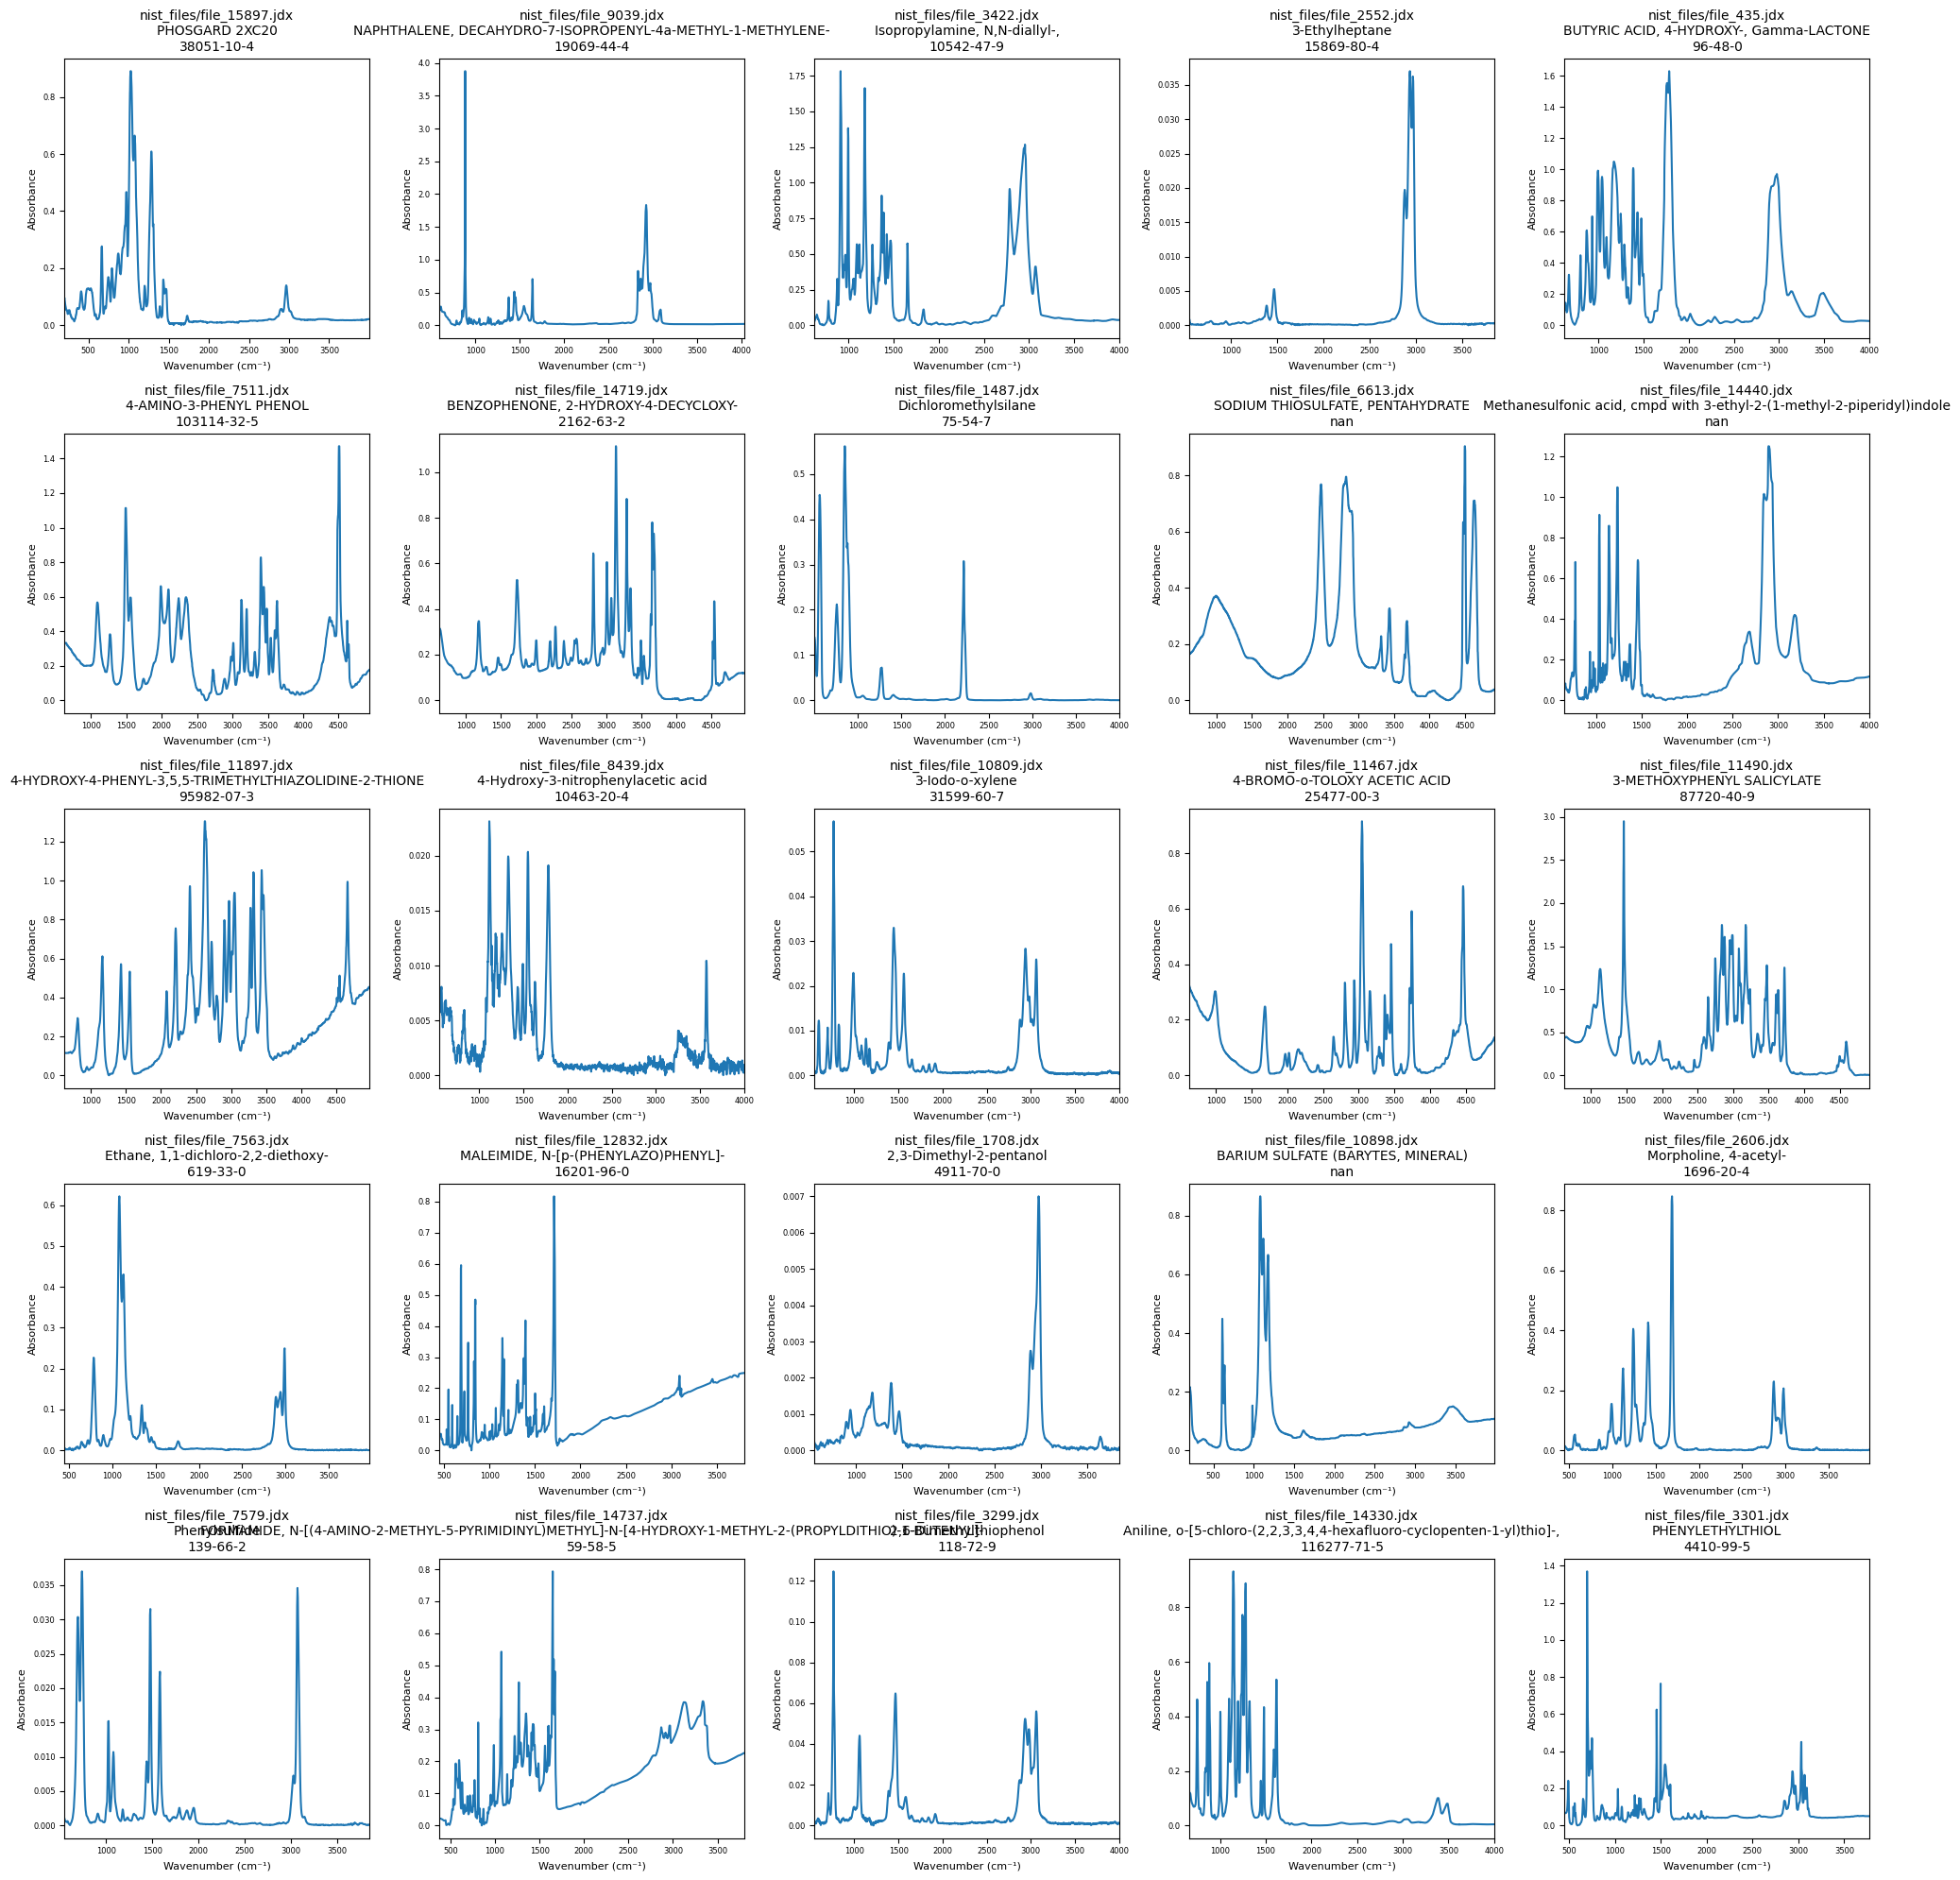

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Randomly select 25 samples from the DataFrame
random_samples = df.sample(n=25)

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Flatten the axes array for easier iteration
axes_flat = axes.flatten()

# Plot each randomly selected spectrum
for i, (idx, row) in enumerate(random_samples.iterrows()):
    ax = axes_flat[i]
    
    # Convert transmittance to absorbance if necessary
    if row['yunits'] == 'TRANSMITTANCE':
        row['y'] = row['y'].clip(0.0001)
        row['y'] = -np.log10(row['y']/100)
        row['y'] = row['y'] - row['y'].min()
        row['yunits'] = 'ABSORBANCE'
    
    # Convert MICROMETERS to wavenumber (cm-1) if necessary
    if row['xunits'] == 'MICROMETERS':
        row['x'] = 10000 / row['x']
        row['firstx'], row['lastx'] = 10000 / row['firstx'], 10000 / row['lastx']
        row['xunits'] = 'WAVENUMBER'

    # Ensure the x values are in ascending order
    if row['firstx'] > row['lastx']:
        row['x'] = row['x'][::-1]
        row['y'] = row['y'][::-1]
        row['firstx'], row['lastx'] = row['lastx'], row['firstx']
    
    # Extract x, y, and range values from the modified row
    x = row['x']
    y = row['y']
    first_x = row['firstx']
    last_x = row['lastx']
    
    # Plot the spectrum with the correct x range
    ax.plot(np.linspace(first_x, last_x, len(x)), y)
    ax.set_title(row['filename'] + "\n" + row['title'] + "\n" + str(row['cas registry no']), fontsize=10)
    ax.set_xlabel("Wavenumber (cm⁻¹)", fontsize=8)
    ax.set_ylabel("Absorbance", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xlim(first_x, last_x)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


### 3) Keep only the points that span the 400-4000 cm-1 range

In [6]:
# Keep only the points that span the 400-4000 cm-1 range
df_filtered = df[(df['firstx'] <= 400) & (df['lastx'] >= 4000)]

# Print the number of rows before and after filtering
print(f"Number of rows before filtering: {len(df)}")
print(f"Number of rows after filtering: {len(df_filtered)}")

# Calculate the percentage of rows kept
percentage_kept = (len(df_filtered) / len(df)) * 100
print(f"Percentage of rows kept: {percentage_kept:.2f}%")

df_filtered


Number of rows before filtering: 14957
Number of rows after filtering: 138
Percentage of rows kept: 0.92%


,filename,title,jcamp-dx,data type,origin,owner,cas registry no,molform,$nist source,state,...,spectral interval after zerofilling,apodization,folding limits,number of interferograms averaged per single channel spectrum,$spectra version,$uncertainty in y,sample description,pressure,temperature,smiles
103,nist_files/file_943.jdx,"PROPANOIC ACID, ETHYL ESTER",4.24,INFRARED SPECTRUM,PERKIN-ELMER CORP. (M. ZELLER),COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,105-37-3,C5 H10 O2,COBLENTZ,VAPOR (10 MICROLITER AT 150 C),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCOC(=O)CC
187,nist_files/file_16039.jdx,Calcium phosphate hydroxide,4.24,INFRARED SPECTRUM,COLGATE-PALMOLIVE COMPANY (KELLENBACH),Copyright (C) 1987 by the Coblentz Society\nCo...,NaN,H2 O26 P6 Ca10,COBLENTZ,"SOLID (1 mg / 100 mg, KBr DISC)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=P([O-])([O-])[O-].O=P([O-])([O-])[O-].O=P([O...
332,nist_files/file_11811.jdx,"Benzoic acid, p-[(3-amino-2-oxopropyl)amino]-,...",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,23852-97-3,C12 H17 N3 O3,COBLENTZ,SOLID (1 mg / 650 mg KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCOC(=O)c1ccc(NCC(CN)=NO)cc1
354,nist_files/file_14955.jdx,"p-Toluenesulfonamide, N-(4-phthalimidobutyl)-",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,15544-49-7,C19 H20 N2 O4 S,COBLENTZ,SOLID (1 mg / 650 mg KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1ccc(S(=O)(=O)NCCCCN2C(=O)c3ccccc3C2=O)cc1
453,nist_files/file_12868.jdx,"9H-purine, 9-benzyl-2, 6-dichloro-",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,79064-26-9,C12 H8 Cl2 N4,COBLENTZ,SOLID (1 mg / 650 mg KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clc1nc(Cl)c2ncn(Cc3ccccc3)c2n1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14474,nist_files/file_15850.jdx,"BENZENE, HEXABROMO-",4.24,INFRARED SPECTRUM,PERKIN-ELMER,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,87-82-1,C6 Br6,COBLENTZ,SOLID (KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brc1c(Br)c(Br)c(Br)c(Br)c1Br
14586,nist_files/file_147.jdx,Sodium nitrite,4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,Copyright (C) 1987 by the Coblentz Society\nCo...,NaN,Na N O2,COBLENTZ,SOLID (1 mg / 650 mg KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=N[O-].[Na+]
14633,nist_files/file_386.jdx,CYCLOHEXANE,4.24,INFRARED SPECTRUM,DOW CHEMICAL COMPANY,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,110-82-7,C6 H12,COBLENTZ,"GAS (25 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1CCCCC1
14850,nist_files/file_8970.jdx,"BENZAMIDE, 2-AMINO-3,5-DICHLORO-",4.24,INFRARED SPECTRUM,SOUTHERN RESEARCH INSTITUTE,COBLENTZ SOCIETY\nCollection (C) 2018 copyrigh...,36765-01-2,C7 H6 Cl2 N2 O,COBLENTZ,SOLID (1 mg / 500 mg KBr DISC),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N=C(O)c1cc(Cl)cc(Cl)c1N


In [12]:
# Display the full DataFrame without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    # Sort the 'state' column alphabetically
    sorted_states = df_filtered['state'].sort_values().dropna()
    
    # Print all the states aligned to the left
    for state in sorted_states:
        print(f"{state:<}")

GAS (10 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)
GAS (25 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)
GAS (6.5 mmHg DILUTED TO A TOTAL PRESSURE OF 600 mmHg WITH N2)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
LIQUID (NEAT)
NEAT
SOLID (1 mg / 100 mg KBr DISC)
SOLID (1 mg / 100 mg KBr DISC)
SOLID (1 mg / 100 mg KBr DISC)
SOLID (1 mg / 100 mg KBr DISC)
SOLID (1 mg / 100 mg KBr DISC)
SOLID (1 mg / 100 mg KBr DISC)
SOLID (1 mg / 100 mg, KBr DISC)
SOLID (1 mg / 100 mg, KBr DISC)
SOLID (1 mg / 100 mg, KBr DISC)
SOLID (1 mg / 100 mg, KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DISC)
SOLID (1 mg / 500 mg KBr DIS

In [45]:
# Calculate and print the range for each datapoint
for index, row in df_filtered.iterrows():
    first_x = row['firstx']
    last_x = row['lastx']
    range_cm = last_x - first_x
    print(f"Datapoint {index}: Range = {range_cm:.2f} cm⁻¹ (from {first_x:.2f} to {last_x:.2f} cm⁻¹)")

# Calculate and print the average range
average_range = df_filtered['lastx'] - df_filtered['firstx']
print(f"\nAverage range: {average_range.mean():.2f} cm⁻¹")

# Calculate and print the minimum and maximum ranges
min_range = average_range.min()
max_range = average_range.max()
print(f"Minimum range: {min_range:.2f} cm⁻¹")
print(f"Maximum range: {max_range:.2f} cm⁻¹")


Datapoint 7: Range = 3516.00 cm⁻¹ (from 450.00 to 3966.00 cm⁻¹)
Datapoint 8: Range = 3606.00 cm⁻¹ (from 402.00 to 4008.00 cm⁻¹)
Datapoint 30: Range = 3516.00 cm⁻¹ (from 450.00 to 3966.00 cm⁻¹)
Datapoint 31: Range = 3339.00 cm⁻¹ (from 457.00 to 3796.00 cm⁻¹)
Datapoint 33: Range = 3569.31 cm⁻¹ (from 236.32 to 3805.63 cm⁻¹)
Datapoint 35: Range = 3340.00 cm⁻¹ (from 460.00 to 3800.00 cm⁻¹)
Datapoint 44: Range = 3516.00 cm⁻¹ (from 450.00 to 3966.00 cm⁻¹)
Datapoint 52: Range = 3370.46 cm⁻¹ (from 429.54 to 3800.00 cm⁻¹)
Datapoint 53: Range = 3336.00 cm⁻¹ (from 460.00 to 3796.00 cm⁻¹)
Datapoint 54: Range = 3516.00 cm⁻¹ (from 450.00 to 3966.00 cm⁻¹)
Datapoint 59: Range = 3346.00 cm⁻¹ (from 454.00 to 3800.00 cm⁻¹)
Datapoint 61: Range = 3394.29 cm⁻¹ (from 402.75 to 3797.03 cm⁻¹)
Datapoint 63: Range = 3516.00 cm⁻¹ (from 450.00 to 3966.00 cm⁻¹)
Datapoint 66: Range = 3342.00 cm⁻¹ (from 458.00 to 3800.00 cm⁻¹)
Datapoint 70: Range = 3342.00 cm⁻¹ (from 458.00 to 3800.00 cm⁻¹)
Datapoint 80: Range = 3516.

# Clean dataframe

In [ ]:
# Calculate the percentage of NaN values in each column
nan_percentage = df.isna().mean() * 100

# Sort the percentage of NaN values in descending order
nan_percentage = nan_percentage.sort_values(ascending=False)

# Print the percentage of NaN values for each column
for index, value in nan_percentage.items():
    original_index = df.columns.get_loc(index) + 1
    print(f"{value:.2f}%: {index} (Original Index: {original_index})")

In [ ]:
import matplotlib.pyplot as plt

# Create a horizontal bar plot for the percentage of NaN values in each column
plt.figure(figsize=(12, 20))
nan_percentage.plot(kind='barh')
plt.title('Percentage of NaN Values in Each Column')
plt.xlabel('Percentage of NaN Values')
plt.ylabel('Columns')
plt.show()

In [ ]:
# Get the columns with less than 10% NaN percentage
columns_less_than_10_percent_nan = nan_percentage[nan_percentage < 10].index.tolist()

# Filter the DataFrame to keep only these columns
df_filtered = df[columns_less_than_10_percent_nan]

# Display the filtered DataFrame
df_filtered
